# Fake News Detection - Kaggle

https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

---

TOC:

1) [Environment](#env)

2) [Machine Learning](#ml)

3) [LDA Topic Modeling](#lda)

4) [LSA Topic Modeling](#lsa)

5) [tSNE](#tsne)

5) [Clustering](#kmeans)

6) [Visualization](#viz)

---

<a class = "anchor" id = "env"></a>

In [9]:
# Install libraries
import sys
#!{sys.executable} -m pip install tensorflow
#!{sys.executable} -m pip install keras
#!{sys.executable} -m pip install xgboost
#!{sys.executable} -m pip install pickle
#!brew install libomp

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [27]:
# Import libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
import umap
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Get user functions
%run '/Users/zxs/Documents/code/zxs.py'

stop_words = stopwords.words('english')

# Function to build a given model
def training_evaluation(model):
    
    m = model
    m.fit(xtrain, ytrain)
    
    preds = m.predict(xval)
    
    print('Results for {}: '.format(model), round(metrics.accuracy_score(preds, yval), 3))
    
    return preds

In [11]:
# Load data
fake = pd.read_csv('/Users/zxs/Documents/data/fake.csv')
real = pd.read_csv('/Users/zxs/Documents/data/true.csv')

In [12]:
%%time

# Assign labels
fake['label'] = 0
real['label'] = 1

# Combine
data = pd.concat([fake, real])
data['all'] = data['title'] + ' ' + data['text']

# Convert dt
data['date'] = pd.to_datetime(data['date'], errors = 'coerce')

# Apply function to parse text
data['parsed'] = data['all'].apply(parse)

CPU times: user 19.5 s, sys: 96.9 ms, total: 19.6 s
Wall time: 19.6 s


In [13]:
# Tokenize text and remove stop words
%time data['tokens'] = data['parsed'].apply(lambda x: [i for i in x.split() if i not in stop_words])

CPU times: user 29.6 s, sys: 220 ms, total: 29.8 s
Wall time: 29.9 s


In [14]:
data.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject       date  \
0  Donald Trump just couldn t wish all Americans ...    News 2017-12-31   
1  House Intelligence Committee Chairman Devin Nu...    News 2017-12-31   
2  On Friday, it was revealed that former Milwauk...    News 2017-12-30   
3  On Christmas day, Donald Trump announced that ...    News 2017-12-29   
4  Pope Francis used his annual Christmas Day mes...    News 2017-12-25   

   label                                                all  \
0      0   Donald Trump Sends Out Embarrassing New Year’...   
1      0   Drunk Bragging Trump Staffer Started Russian ...   
2      0   Sheriff David Clarke Becomes An Internet Joke...   
3      0   Trump Is So Obsessed He Even Has Obama’s Name...   
4      0   Pope Francis Just Called Out Donald Trump Dur...   

                                              parsed  \
0   donald trump sends out embarrassing new year’...   
1   drunk bragging trump staffer started russian ...   
2   sheriff david clarke becomes an internet joke...   
3   trump is so obsessed he even has obama’s name...   
4   pope francis just called out donald trump dur...   

                                              tokens  
0  [donald, trump, sends, embarrassing, new, year...  
1  [drunk, bragging, trump, staffer, started, rus...  
2  [sheriff, david, clarke, becomes, internet, jo...  
3  [trump, obsessed, even, obama’s, name, coded, ...  
4  [pope, francis, called, donald, trump, christm...

---
<a class = "anchor" id = "ml"></a>

In [17]:
%%time

# Initialize vec
cv = CountVectorizer()
x = cv.fit_transform(data['tokens'].apply(lambda x: ' '.join(x)))

# Split data for training / testing
xtrain, xval, ytrain, yval = train_test_split(x, data['label'], test_size = .3, random_state = 100)

CPU times: user 7.32 s, sys: 106 ms, total: 7.43 s
Wall time: 7.43 s


In [18]:
# Build xgboost model
preds = training_evaluation(xgb.XGBClassifier())

Results for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None):  0.997


---

<a class = "anchor" id = "lda"></a>

In [ ]:
# Use vectorized data for topic modeling
cs = []
ps = []

for n in range(1, 20, 1):
    
    # Init the Model
    lda = LatentDirichletAllocation(n_components = n, max_iter = 5, learning_method = 'online', learning_offset = 50, random_state = 100, n_jobs = -2, verbose = 1)
    lda.fit(corpus)
    
    # Compute coherence
    cm = CoherenceModel(model = lda, texts = data['tokens'], dictionary = wordid, coherence = 'c_v')
    
    if cm.get_coherence() == 'nan':
        
        print('SNAFU!!!')
        break
        
    cs.append(cm.get_coherence())
    ps.append(cm.get_perplexity())
    
    print('Coherence for model w/{} topics: '.format(n), cm.get_coherence())

---

<a class = "anchor" id = "lsa"></a>

In [23]:
# Optimize the # of components
variance = []

for n in range(1, 20, 1):
               
    # SVD represent documents and terms in vectors 
    svd = TruncatedSVD(n_components = n, algorithm = 'randomized', n_iter = 5, random_state = 100)
    svd.fit(x)
    
    # Store variance
    variance.append(svd.explained_variance_ratio_.sum())
    print('Variance for Model w/{} Topics- '.format(n), svd.explained_variance_ratio_.sum())

Variance for Model w/1 Topics-  0.056476445262139054
Variance for Model w/2 Topics-  0.08963092611011525
Variance for Model w/3 Topics-  0.1081525931863491
Variance for Model w/4 Topics-  0.12180421042378894
Variance for Model w/5 Topics-  0.13383879762098916
Variance for Model w/6 Topics-  0.14506845780375127
Variance for Model w/7 Topics-  0.15448636783413072
Variance for Model w/8 Topics-  0.16281640320035867
Variance for Model w/9 Topics-  0.17075818620600172
Variance for Model w/10 Topics-  0.17751212029956281
Variance for Model w/11 Topics-  0.18386113140845367
Variance for Model w/12 Topics-  0.18979545094123534
Variance for Model w/13 Topics-  0.19570559271072654
Variance for Model w/14 Topics-  0.20131527849101527
Variance for Model w/15 Topics-  0.2063733549534415
Variance for Model w/16 Topics-  0.21105518548547553
Variance for Model w/17 Topics-  0.21550638409339715
Variance for Model w/18 Topics-  0.21984202316065407
Variance for Model w/19 Topics-  0.224159455363046


In [25]:
# Build optimized model
svd = TruncatedSVD(n_components = 5, algorithm = 'randomized', n_iter = 5, random_state = 100)
svd.fit(x)   
terms = cv.get_feature_names()

# Inspect features
for i, comp in enumerate(svd.components_):
    
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key =  lambda x:x[1], reverse = True)[:7]
    
    print("Topic " + str(i) + ": ")
    
    print([x[0] for x in sorted_terms])
    
# Get topic distribution
svdtopics = svd.fit_transform(x)

# Assign to data
data['topic'] = [x.argmax() for x in svdtopics]
data['topic'].value_counts()

Topic 0: 
['trump', 'said', 'us', 'would', 'president', 'people', 'one']
Topic 1: 
['said', 'us', 'government', 'state', 'would', 'reuters', 'also']
Topic 2: 
['clinton', 'media', 'hillary', 'one', 'news', 'people', 'like']
Topic 3: 
['us', 'north', 'korea', 'united', 'states', 'russia', 'china']
Topic 4: 
['clinton', 'us', 'hillary', 'campaign', 'russia', 'russian', 'fbi']


---
<a class = "anchor" id = "elda"></a>

---
<a class = "anchor" id = "tsne"></a>

In [34]:
# Perform t-SNE to visualize predicted differences
tsne = TSNE(n_components = 2, random_state = 100, n_jobs = -2, verbose = 1)

out = tsne.fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 44898 samples in 0.017s...
[t-SNE] Computed neighbors for 44898 samples in 61.359s...
[t-SNE] Computed conditional probabilities for sample 1000 / 44898
[t-SNE] Computed conditional probabilities for sample 2000 / 44898
[t-SNE] Computed conditional probabilities for sample 3000 / 44898
[t-SNE] Computed conditional probabilities for sample 4000 / 44898
[t-SNE] Computed conditional probabilities for sample 5000 / 44898
[t-SNE] Computed conditional probabilities for sample 6000 / 44898
[t-SNE] Computed conditional probabilities for sample 7000 / 44898
[t-SNE] Computed conditional probabilities for sample 8000 / 44898
[t-SNE] Computed conditional probabilities for sample 9000 / 44898
[t-SNE] Computed conditional probabilities for sample 10000 / 44898
[t-SNE] Computed conditional probabilities for sample 11000 / 44898
[t-SNE] Computed conditional probabilities for sample 12000 / 44898
[t-SNE] Computed conditional probabilities for sa

In [35]:
# Assign scores to data
data['t1'] = out[:, 0]
data['t2'] = out[:, 1]

---
<a class = "anchor" id = "kmeans"></a>

In [46]:
# Optimize KMeans
ssd = []

for n in range(1, 20, 1):
    
    m = KMeans(n_clusters = n, init = 'k-means++', random_state = 100)
    m.fit(data[['topic', 't1', 't2']])
    ssd.append(m.inertia_)

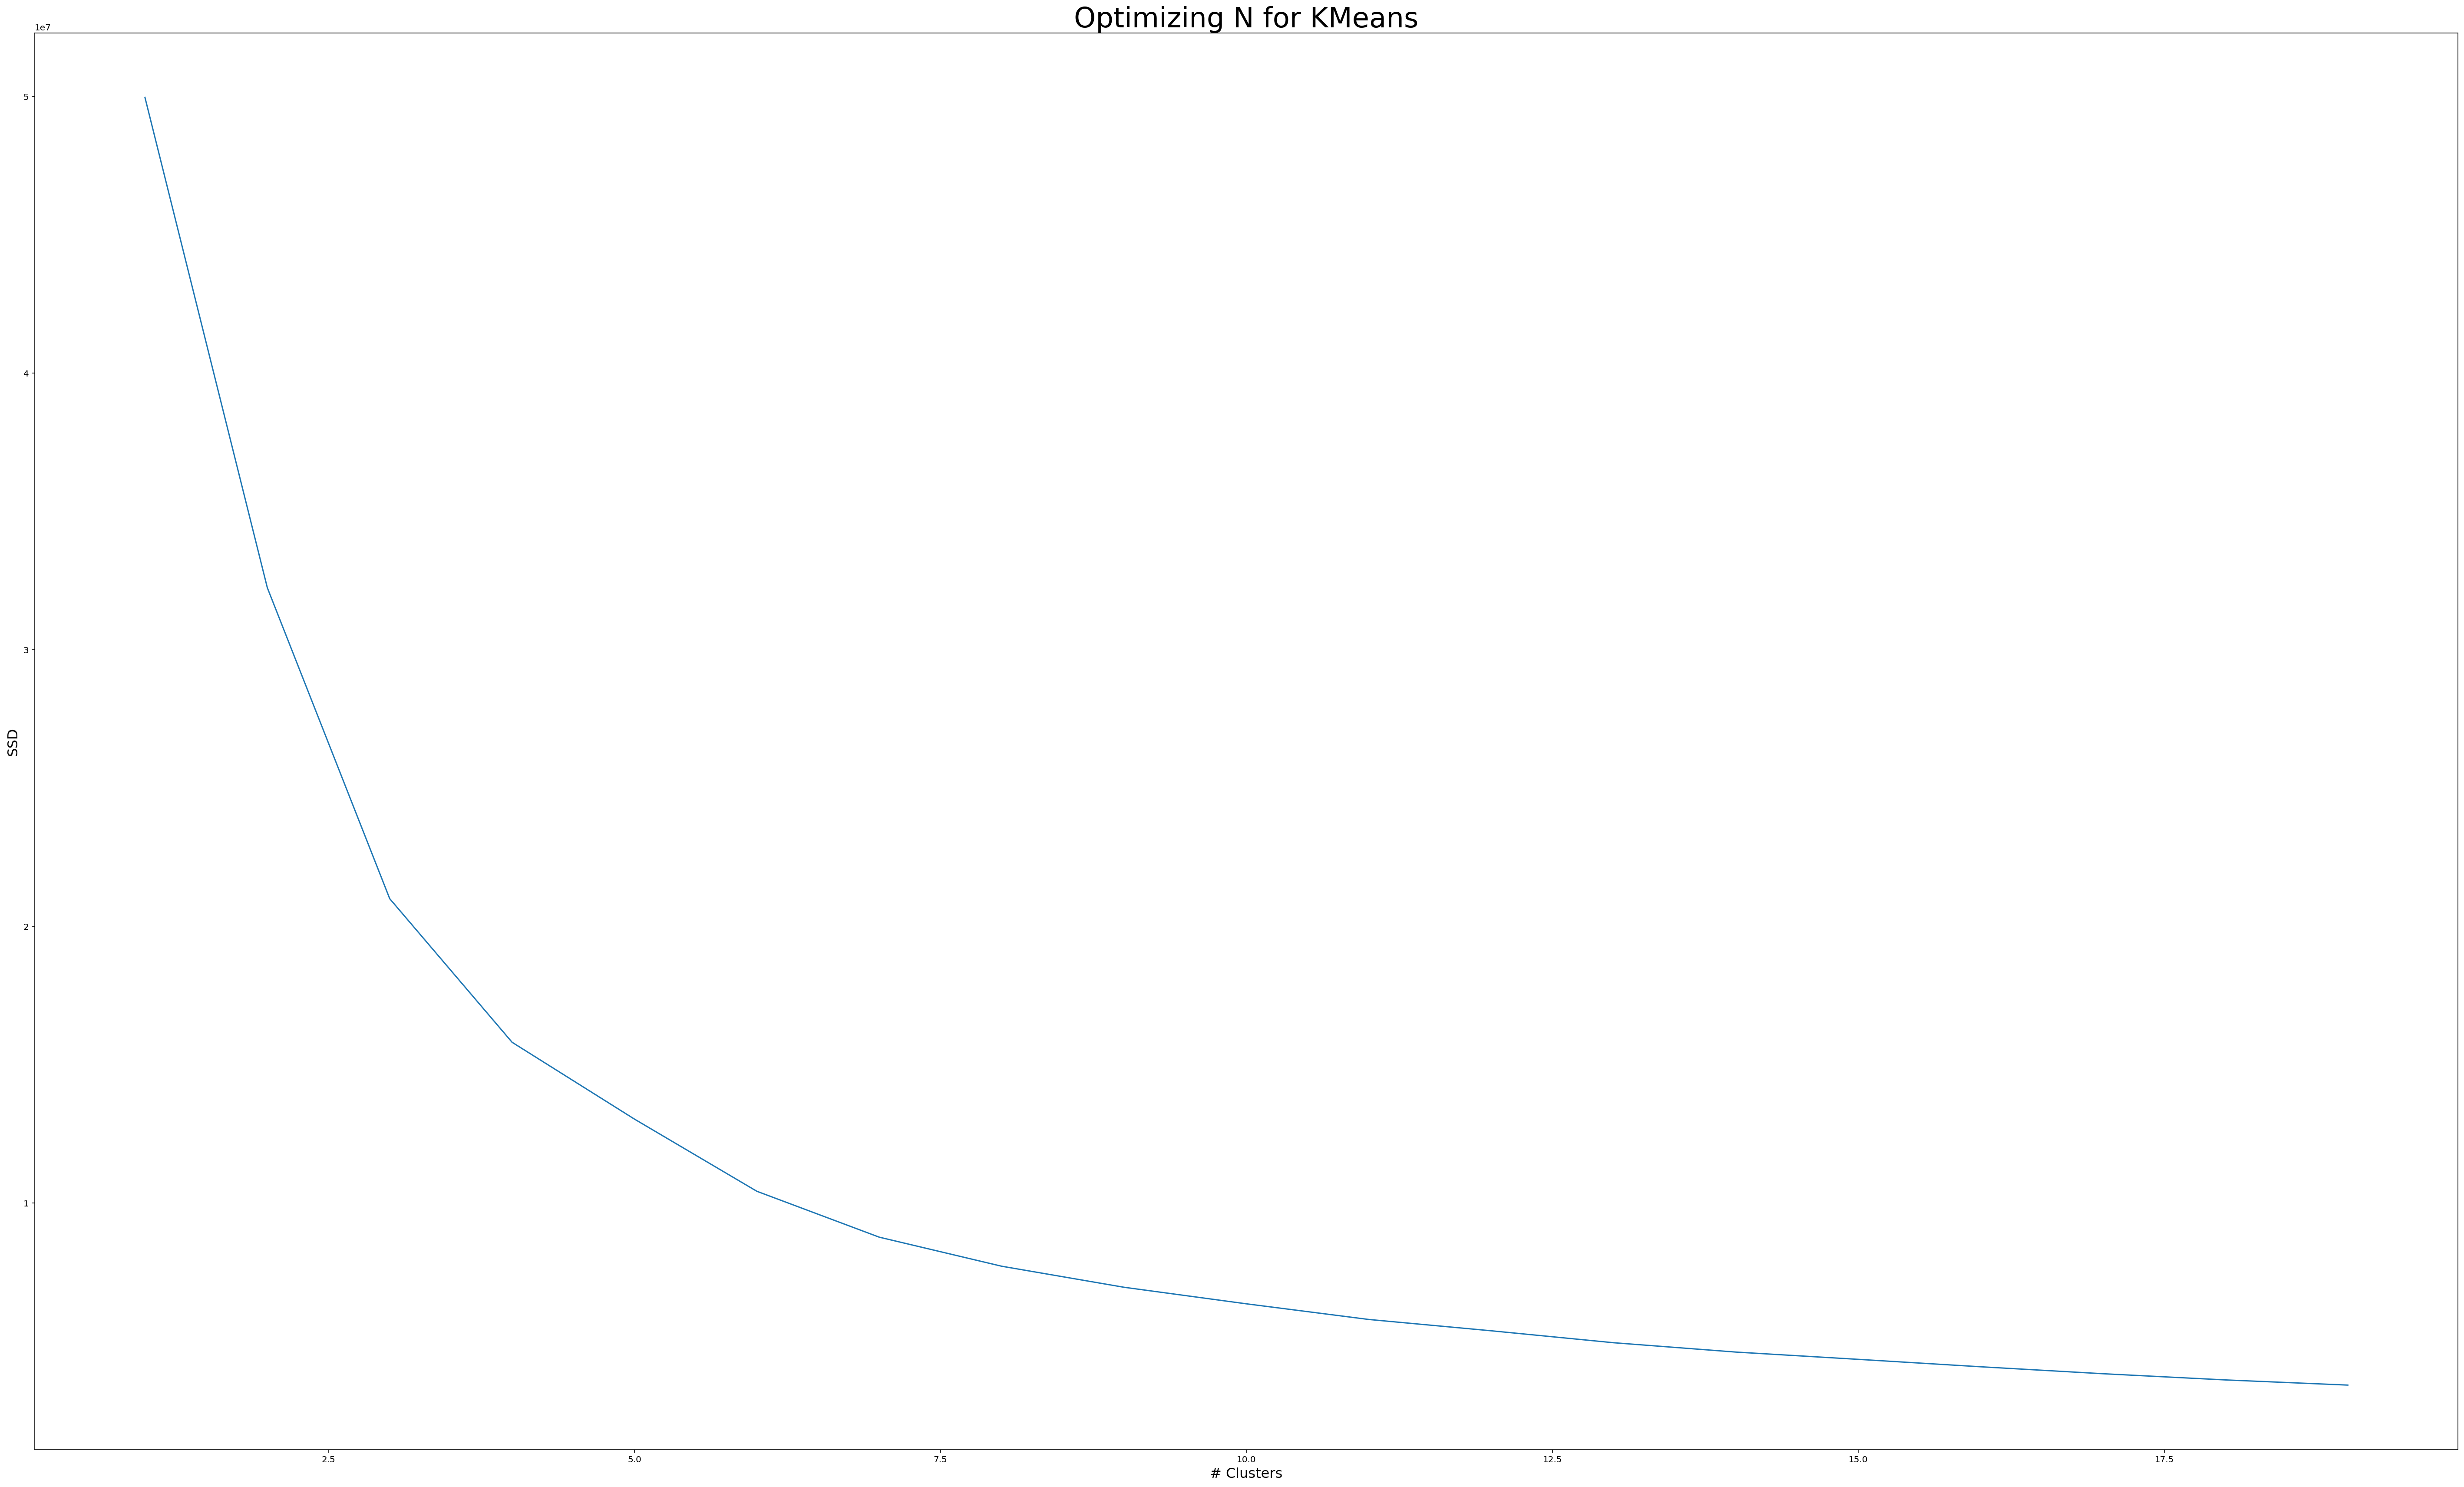

In [47]:
plt.figure(figsize = [50, 30])
plt.title('Optimizing N for KMeans', fontsize = 32)
plt.xlabel('# Clusters', fontsize = 16)
plt.ylabel('SSD', fontsize = 16)
plt.plot([i for i in range(1, 20, 1)], ssd)

In [48]:
# Build optimized model
m = KMeans(n_clusters = 10, init = 'k-means++', random_state = 100)
m.fit(data[['topic', 't1', 't2']])

# Assign labels
data['cluster'] = m.labels_

In [49]:
print('Cluster Distribution: ')
data['cluster'].value_counts()

Cluster Distribution: 


1    6881
7    5313
8    4624
3    4381
4    4280
9    4273
6    4092
5    3971
0    3923
2    3160
Name: cluster, dtype: int64

---
<a class = "anchor" id = "viz"></a>

In [ ]:
%%time

# Calculate embeddings
embedding = umap.UMAP(n_neighbors = 150, min_dist = 0.5, random_state = 100).fit_transform(svdtopics)

# Assign scores to content
data['e1'] = embedding[:, 0]
data['e2'] = embedding[:, 1]

Embedding scores for data:


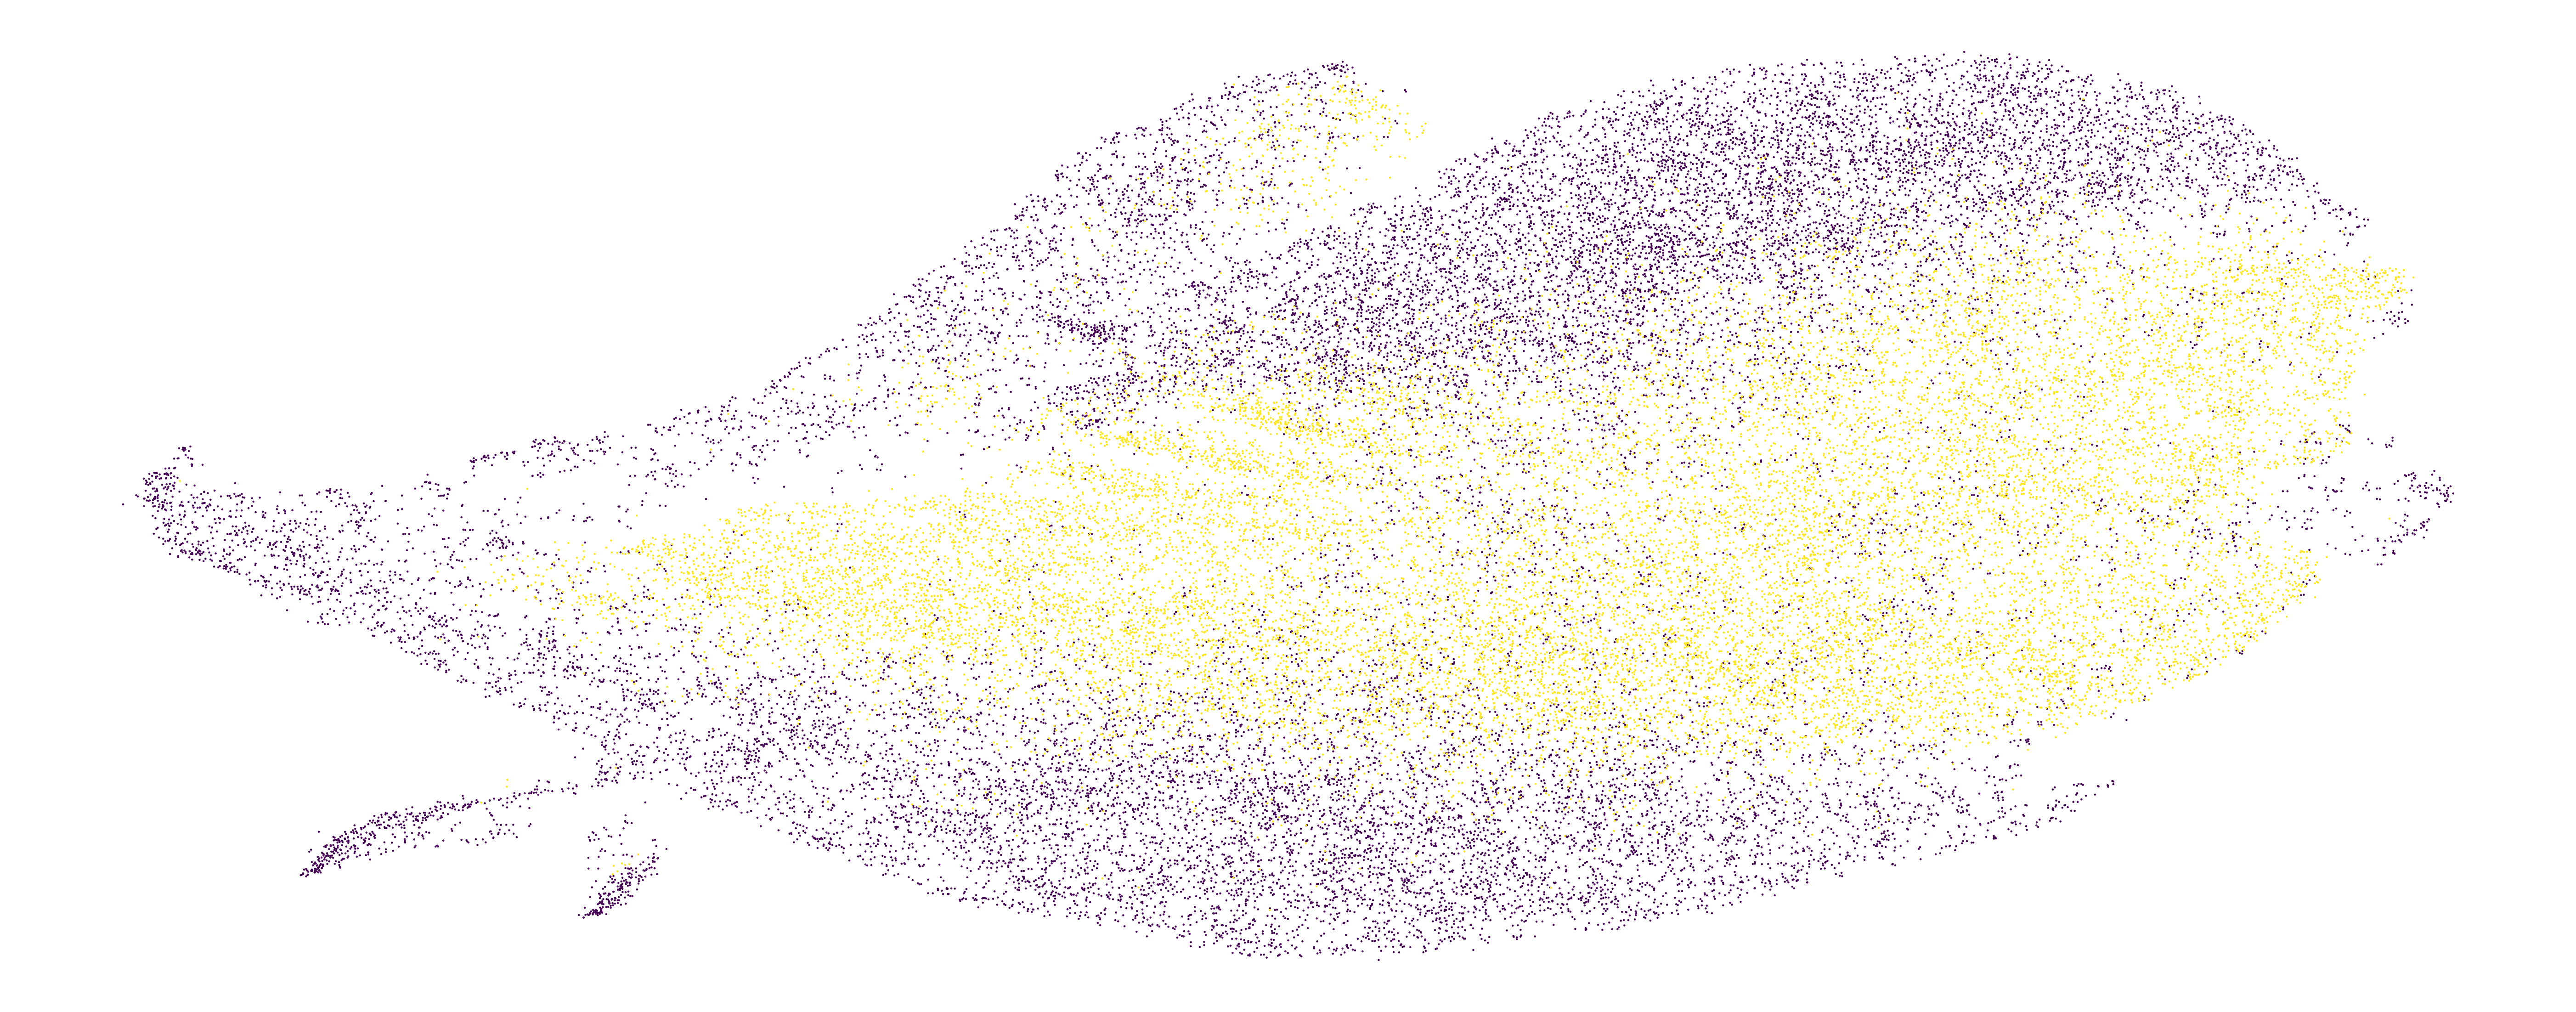

In [40]:
# Visualize
print('Embedding scores for data:')
plt.figure(figsize = [50, 20])
plt.scatter(embedding[:, 0], embedding[:, 1], c = data.label, s = 5, edgecolor = 'none')
plt.axis('off')
plt.show()

tSNE scores for data:


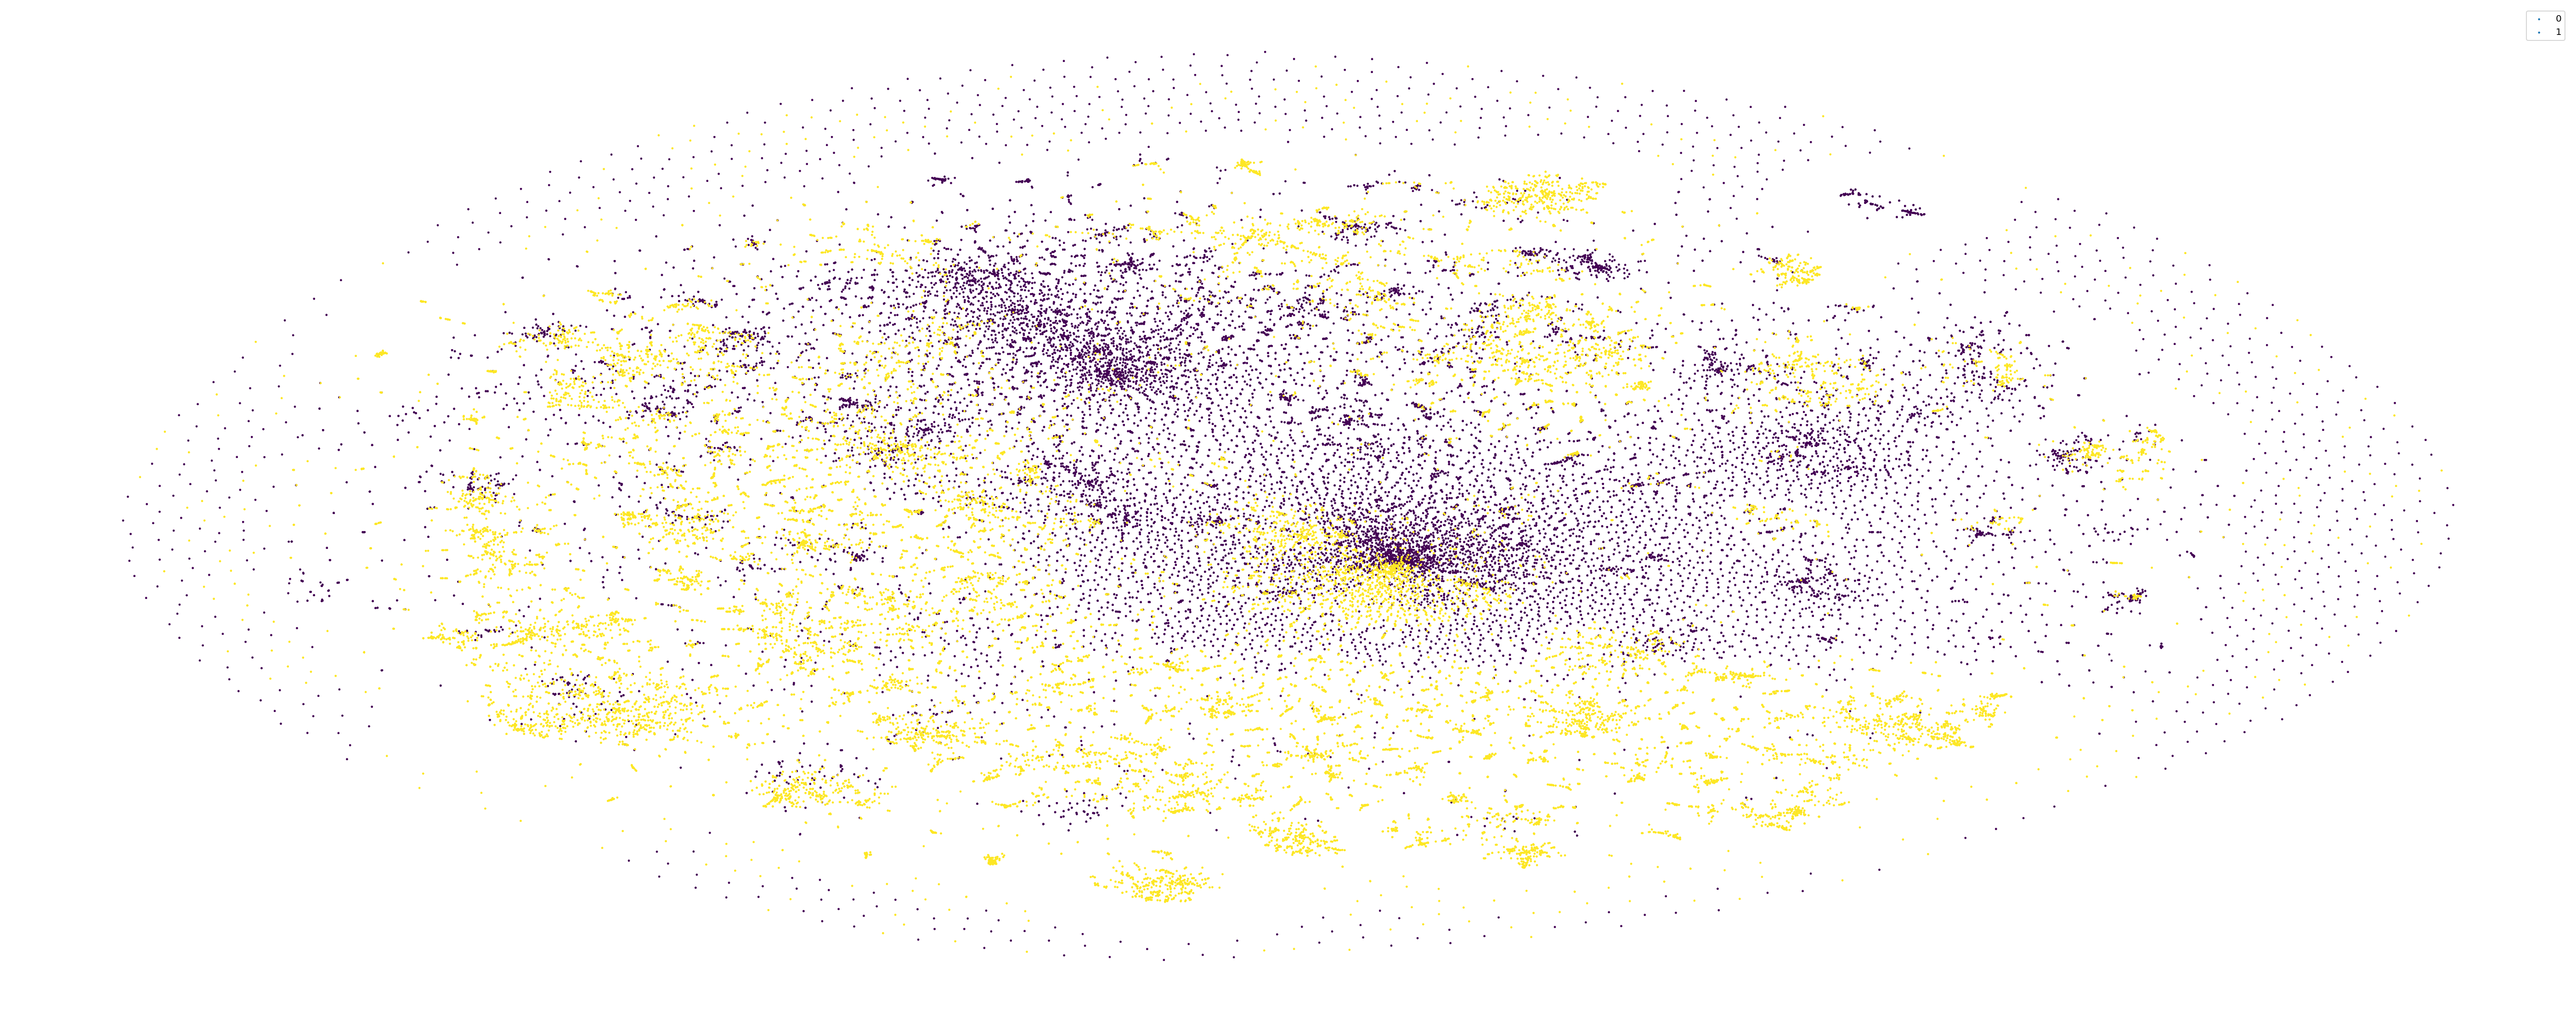

In [41]:
# Visualize
print('tSNE scores for data:')
plt.figure(figsize = [50, 20])

for nm, grp in data.groupby('label'):
    
    plt.scatter(out[:, 0], out[:, 1], c = data.label, s = 5, edgecolor = 'none', label = nm)
    
plt.legend()
plt.axis('off')
plt.show()

tSNE scores by cluster for data:


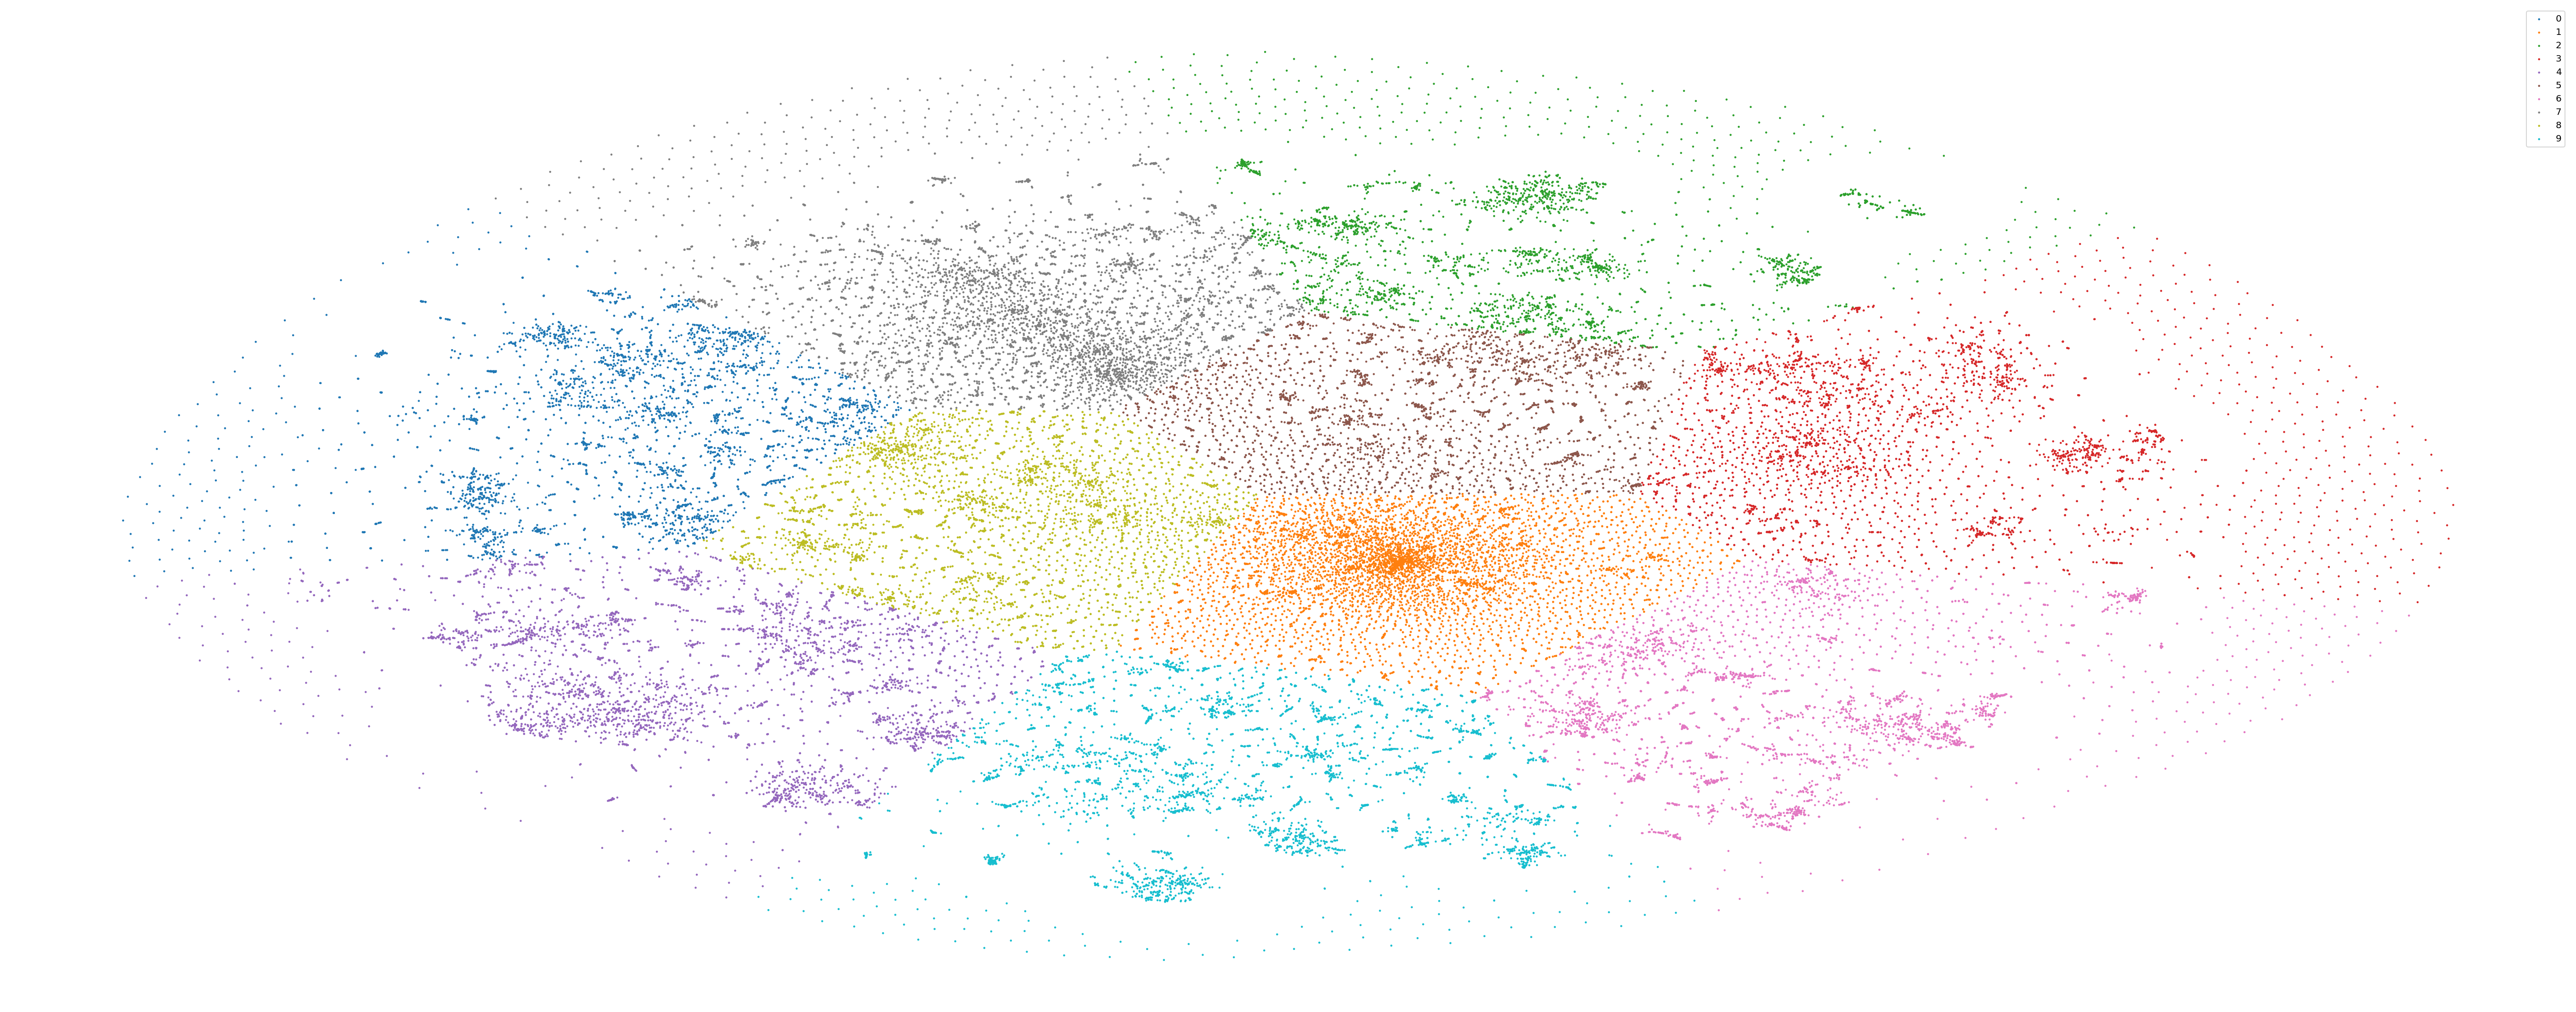

In [52]:
# Visualize
print('tSNE scores by cluster for data:')
plt.figure(figsize = [50, 20])

for nm, grp in data.groupby('cluster'):
    
    plt.scatter(grp['t1'], grp['t2'], s = 5, edgecolor = 'none', label = nm)
    
plt.legend()
plt.axis('off')
plt.show()